![DLI Header](images/DLI_Header.png)

# Token Classification with Large Language Models #

## 02 - Domain-Specific Token Classification Model ##

In this notebook, you will learn to fine-tune a pre-trained language model to perform token classification for specific domains. Specifically, you will develop an NER model that finds disease names in medical disease abstracts. 

**Table of Contents**<br>
This notebook covers the below sections: 
* Project Overview
* Dataset
    * Download Data
    * Preprocess Data
* Fine-Tune a Pre-Trained Model for Custom Domain
    * Configuration File
    * Download Domain-Specific Pre-Trained Model
    * Exercise # 1 - Instantiate Model and Trainer
    * Exercise # 2 - Model Training
    * Model Evaluation

## Project Overview ##

<img src='images/workflow.png' width=1080>

## Dataset ##

For this notebook, we're going to use the [NCBI-disease](https://www.ncbi.nlm.nih.gov/CBBresearch/Dogan/DISEASE/) corpus, which is a set of 793 PubMed abstracts, annotated by 14 annotators. The annotations take the form of HTML-style tags inserted into the abstract text using the clearly defined rules. The annotations identify named diseases and can be used to fine-tune a language model to identify disease mentions in future abstracts, *whether those diseases were part of the original training set or not*.  

### Download Data ###

In [1]:
import os
import wget

# set data path
DATA_DIR = "data/NCBI"
os.makedirs(DATA_DIR, exist_ok=True)

Here's an example of what an annotated abstract from the corpus looks like: 

In [2]:
with open(f'{DATA_DIR}/NCBI_corpus_testing.txt') as f: 
    sample_text=f.readline()
    
print(sample_text)

9288106	Clustering of missense mutations in the <category="Modifier">ataxia-telangiectasia</category> gene in a <category="SpecificDisease">sporadic T-cell leukaemia</category>.	<category="SpecificDisease">Ataxia-telangiectasia</category> ( <category="SpecificDisease">A-T</category> ) is a <category="DiseaseClass">recessive multi-system disorder</category> caused by mutations in the ATM gene at 11q22-q23 ( ref . 3 ) . The risk of <category="DiseaseClass">cancer</category> , especially <category="DiseaseClass">lymphoid neoplasias</category> , is substantially elevated in <category="Modifier">A-T</category> patients and has long been associated with chromosomal instability . By analysing <category="Modifier">tumour</category> DNA from patients with <category="SpecificDisease">sporadic T-cell prolymphocytic leukaemia</category> ( <category="SpecificDisease">T-PLL</category> ) , a rare <category="DiseaseClass">clonal malignancy</category> with similarities to a <category="SpecificDisease">

In this example, we see the following tags within the abstract:

In [3]:
import re

# use regular expression to find labels
categories=re.findall('<category.*?<\/category>', sample_text)
for sample in categories: 
    print(sample)

<category="Modifier">ataxia-telangiectasia</category>
<category="SpecificDisease">sporadic T-cell leukaemia</category>
<category="SpecificDisease">Ataxia-telangiectasia</category>
<category="SpecificDisease">A-T</category>
<category="DiseaseClass">recessive multi-system disorder</category>
<category="DiseaseClass">cancer</category>
<category="DiseaseClass">lymphoid neoplasias</category>
<category="Modifier">A-T</category>
<category="Modifier">tumour</category>
<category="SpecificDisease">sporadic T-cell prolymphocytic leukaemia</category>
<category="SpecificDisease">T-PLL</category>
<category="DiseaseClass">clonal malignancy</category>
<category="SpecificDisease">mature T-cell leukaemia</category>
<category="SpecificDisease">A-T</category>
<category="SpecificDisease">T-PLL</category>
<category="SpecificDisease">A-T</category>
<category="DiseaseClass">leukaemia</category>
<category="SpecificDisease">T-PLL</category>
<category="Modifier">A-T</category>
<category="Modifier">tumour</catego

For our purposes, we will consider any identified category (such as "Modifier", "Specific Disease", and a few others) to generally be a "disease".  If you want to see more examples, you can explore the text of the corpus using the file browser to the left, or open files directly: 

* [data/NCBI/NCBI_corpus_training.txt](data/NCBI/NCBI_corpus_training.txt)
* [data/NCBI/NCBI_corpus_testing.txt](data/NCBI/NCBI_corpus_testing.txt)
* [data/NCBI/NCBI_corpus_development.txt](data/NCBI/NCBI_corpus_development.txt)

We have already derived a dataset from this corpus. For NER, the dataset labels individual words as diseases. 

In [4]:
NER_DATA_DIR = f'{DATA_DIR}/NER'
os.makedirs(os.path.join(DATA_DIR, 'NER'), exist_ok=True)

# show downloaded files
!ls -lh $NER_DATA_DIR

total 1.5M
-rw-r--r-- 1 root root 196K Jan  6 03:19 dev.tsv
-rw-r--r-- 1 root root 201K Jan  6 03:19 test.tsv
-rw-r--r-- 1 root root 1.1M Jan  6 03:19 train.tsv


In [5]:
!head $NER_DATA_DIR/train.tsv

Identification	O
of	O
APC2	O
,	O
a	O
homologue	O
of	O
the	O
adenomatous	B-Disease
polyposis	I-Disease


_Note:_ We can see that the abstract has been broken into sentences. Each sentence is then further parsed into words with labels that correspond to the original HTML-style tags in the corpus.

### Preprocess Data ###

We need to convert these to a format that is compatible with NeMo token classification module. For convenience, we've provided the script for this conversion [here](https://github.com/NVIDIA/NeMo/blob/stable/examples/nlp/token_classification/data/import_from_iob_format.py). 

In [6]:
# invoke the conversion script 
!python import_from_iob_format.py --data_file=$NER_DATA_DIR/train.tsv
!python import_from_iob_format.py --data_file=$NER_DATA_DIR/dev.tsv
!python import_from_iob_format.py --data_file=$NER_DATA_DIR/test.tsv

NOTE! Installing ujson may make loading annotations faster.
[NeMo I 2025-01-06 04:17:12 import_from_iob_format:119] Processing data/NCBI/NER/train.tsv
[NeMo I 2025-01-06 04:17:12 import_from_iob_format:124] Processing of the data/NCBI/NER/train.tsv is complete
NOTE! Installing ujson may make loading annotations faster.
[NeMo I 2025-01-06 04:17:17 import_from_iob_format:119] Processing data/NCBI/NER/dev.tsv
[NeMo I 2025-01-06 04:17:17 import_from_iob_format:124] Processing of the data/NCBI/NER/dev.tsv is complete
NOTE! Installing ujson may make loading annotations faster.
[NeMo I 2025-01-06 04:17:21 import_from_iob_format:119] Processing data/NCBI/NER/test.tsv
[NeMo I 2025-01-06 04:17:21 import_from_iob_format:124] Processing of the data/NCBI/NER/test.tsv is complete


Recall that the sentences and labels in the NER dataset map to each other with _inside, outside, beginning (IOB)_ tagging. Anything separated by white space is a word, including punctuation. This mechanism can be used in a general way for multiple named entity types:
* B-{CHUNK_TYPE} – for the word in the Beginning chunk
* I-{CHUNK_TYPE} – for words Inside the chunk
* O – Outside any chunk

In our case, we are only looking for "disease" as our entity (or chunk) type, so we don't need to identify beyond the three classes: I, O, and B.
**Three classes**
* B - Beginning of disease name
* I - Inside word of disease name
* O - Outside of all disease names

As an example, for the first sentence we have the following mapping: 

```text
Identification of APC2 , a homologue of the adenomatous polyposis coli tumour suppressor .
O              O  O    O O O         O  O   B           I         I    I      O          O  
```

For comparison, the original corpus tags looked like:
```html
Identification of APC2, a homologue of the <category="Modifier">adenomatous polyposis coli tumour</category> suppressor.
```

The beginning word of the tagged text, "adenomatous", is now IOB-tagged with a **B** (beginning) tag, the other parts of the disease, "polyposis coli tumour" tagged with **I** (inside) tags, and everything else tagged as **O** (outside).

In [7]:
# preview dataset
!head -n 1 $NER_DATA_DIR/text_train.txt
!head -n 1 $NER_DATA_DIR/labels_train.txt

Identification of APC2 , a homologue of the adenomatous polyposis coli tumour suppressor . 
O O O O O O O O B-Disease I-Disease I-Disease I-Disease O O 


## Fine-Tune a Pre-Trained Model for Custom Domain ##

A name entity recognition model is typically comprised of a pre-trained [BERT](https://arxiv.org/pdf/1810.04805.pdf) model followed by a token classification layer. For training, we can use a configuration file to define the model. The configuration (config) file consists of several important sections, including: 
* **model**: All arguments that are related to the Model - language model, token classifier, optimizer and schedulers, datasets and any other related information
* **trainer**: Any argument to be passed to PyTorch Lightning

_Note:_ NeMo provides a template for creating the configuration file, which is recommended as a starting point, but you can create your own as long as it follows the required format. 

### Configuration File ###

In [8]:
# define config path
MODEL_CONFIG = "token_classification_config.yaml"
WORK_DIR = "WORK_DIR"
os.makedirs(WORK_DIR, exist_ok=True)

In [9]:
# download the model's configuration file 
BRANCH = 'main'
config_dir = WORK_DIR + '/configs/'
os.makedirs(config_dir, exist_ok=True)

if not os.path.exists(config_dir + MODEL_CONFIG):
    print('Downloading config file...')
    wget.download(f'https://raw.githubusercontent.com/NVIDIA/NeMo/{BRANCH}/examples/nlp/token_classification/conf/' + MODEL_CONFIG, config_dir)
else:
    print ('config file already exists')

The config file for NER, `token_classification_config.yaml`, specifies model, training, and experiment management details, such as file locations, pretrained models, and hyperparameters. The YAML config file we downloaded provides default values for most of the parameters, but there are a few items that must be specified for this experiment.

Each YAML section is a bit easier to view using the `omegaconf` package, which allows you to access and manipulate the configuration keys using a "dot" notation. We'll take a look at the details of each section using the `OmegaConf` tool. 

In [10]:
from omegaconf import OmegaConf

CONFIG_DIR = "/dli/task/WORK_DIR/configs"
CONFIG_FILE = "token_classification_config.yaml"

config=OmegaConf.load(CONFIG_DIR + "/" + CONFIG_FILE)

# print the entire configuration file
print(OmegaConf.to_yaml(config))

pretrained_model: null
trainer:
  devices: 1
  num_nodes: 1
  max_epochs: 5
  max_steps: -1
  accumulate_grad_batches: 1
  gradient_clip_val: 0.0
  precision: 16
  accelerator: gpu
  enable_checkpointing: false
  logger: false
  log_every_n_steps: 1
  val_check_interval: 1.0
exp_manager:
  exp_dir: null
  name: token_classification_model
  create_tensorboard_logger: true
  create_checkpoint_callback: true
model:
  label_ids: null
  class_labels:
    class_labels_file: label_ids.csv
  dataset:
    data_dir: ???
    class_balancing: null
    max_seq_length: 128
    pad_label: O
    ignore_extra_tokens: false
    ignore_start_end: false
    use_cache: false
    num_workers: 2
    pin_memory: false
    drop_last: false
  train_ds:
    text_file: text_train.txt
    labels_file: labels_train.txt
    shuffle: true
    num_samples: -1
    batch_size: 64
  validation_ds:
    text_file: text_dev.txt
    labels_file: labels_dev.txt
    shuffle: false
    num_samples: -1
    batch_size: 64
  test_

Notice that some config lines, including `model.dataset.data_dir`, have `???` in place of paths, this means that values for these fields are required to be specified by the user. Details about the model arguments can be found in the [documentation](https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/token_classification.html#training-the-token-classification-model). 

In [11]:
# in this exercise, train and dev datasets are located in the same folder under the default names, 
# so it is enough to add the path of the data directory to the config
config.model.dataset.data_dir = os.path.join(DATA_DIR, 'NER')

# print the model section
print(OmegaConf.to_yaml(config.model))

label_ids: null
class_labels:
  class_labels_file: label_ids.csv
dataset:
  data_dir: data/NCBI/NER
  class_balancing: null
  max_seq_length: 128
  pad_label: O
  ignore_extra_tokens: false
  ignore_start_end: false
  use_cache: false
  num_workers: 2
  pin_memory: false
  drop_last: false
train_ds:
  text_file: text_train.txt
  labels_file: labels_train.txt
  shuffle: true
  num_samples: -1
  batch_size: 64
validation_ds:
  text_file: text_dev.txt
  labels_file: labels_dev.txt
  shuffle: false
  num_samples: -1
  batch_size: 64
test_ds:
  text_file: text_dev.txt
  labels_file: labels_dev.txt
  shuffle: false
  num_samples: -1
  batch_size: 64
tokenizer:
  tokenizer_name: ${model.language_model.pretrained_model_name}
  vocab_file: null
  tokenizer_model: null
  special_tokens: null
language_model:
  pretrained_model_name: bert-base-uncased
  lm_checkpoint: null
  config_file: null
  config: null
head:
  num_fc_layers: 2
  fc_dropout: 0.5
  activation: relu
  use_transformer_init: true


_Note:_ The required `model.dataset.data_dir` argument (for token classification) has been modified. 

### Download Domain-Specific Pre-Trained Model ###

For this token classification task, we can start with the pre-trained `BioMegatron` language model. The `BioMegatron` model is a domain-specific, BERT-like Megatron-LM model trained on large biomedical text corpus. Since the model was trained on domain-specific text, we can expect to have better performance compared to the general language model for identifying disease. 

_Note:_ There are alternatives of BioMegatron such as BioBERT. It's worth experimenting with different pre-trained models to find the one that provide optimal performance for a specific task. 

In [29]:
# import dependencies
from nemo.collections.nlp.models.language_modeling.megatron_bert_model import MegatronBertModel

# list available pre-trained models
for model in MegatronBertModel.list_available_models(): 
    print(model.pretrained_model_name)

megatron_bert_345m_cased
megatron_bert_345m_uncased
biomegatron345m_biovocab_50k_cased
biomegatron345m_biovocab_50k_uncased
biomegatron345m_biovocab_30k_cased
biomegatron345m_biovocab_30k_uncased
biomegatron-bert-345m-cased
biomegatron-bert-345m-uncased


To load the pretrained BERT LM model, we change the `model.language_mode` argument in the config as well as a few other arguments. 

In [31]:
# add the specified above model parameters to the config
MODEL_NAME='biomegatron345m_biovocab_30k_cased'
# MODEL_NAME='biomegatron-bert-345m-cased'

config.model.language_model.lm_checkpoint=None
config.model.language_model.pretrained_model_name=MODEL_NAME
config.model.tokenizer.tokenizer_name=None

# use appropriate configurations based on GPU capacity
config.model.dataset_max_seq_length=64
config.model.train_ds.batch_size=32
config.model.validation_ds.batch_size=32
config.model.test_ds.batch_size=32

# limit the number of epochs for this demonstration
config.trainer.max_epochs=1
# config.trainer.precision=16
# config.trainer.amp_level='O1'

# print the model section
print(OmegaConf.to_yaml(config.model))

label_ids: null
class_labels:
  class_labels_file: label_ids.csv
dataset:
  data_dir: data/NCBI/NER
  class_balancing: null
  max_seq_length: 128
  pad_label: O
  ignore_extra_tokens: false
  ignore_start_end: false
  use_cache: false
  num_workers: 2
  pin_memory: false
  drop_last: false
train_ds:
  text_file: text_train.txt
  labels_file: labels_train.txt
  shuffle: true
  num_samples: -1
  batch_size: 32
validation_ds:
  text_file: text_dev.txt
  labels_file: labels_dev.txt
  shuffle: false
  num_samples: -1
  batch_size: 32
test_ds:
  text_file: text_dev.txt
  labels_file: labels_dev.txt
  shuffle: false
  num_samples: -1
  batch_size: 32
tokenizer:
  tokenizer_name: null
  vocab_file: null
  tokenizer_model: null
  special_tokens: null
language_model:
  pretrained_model_name: biomegatron345m_biovocab_30k_cased
  lm_checkpoint: null
  config_file: null
  config: null
head:
  num_fc_layers: 2
  fc_dropout: 0.5
  activation: relu
  use_transformer_init: true
optim:
  name: adam
  lr

_Note:_ Once the `token_classification_config.yaml` file has been loaded into memory, changing the configuration file will require the `config` variable to be re-defined. 

Now, we are ready to initialize our model. During the model initialization call, the dataset and data loaders will be prepared for training and evaluation. Also, the pretrained BERT model will be downloaded, which can take up to a few minutes depending on the size of the chosen BERT model.

#### Exercise # 1 - Instantiate Model and Trainer ####

* Modify the `<FIXME>` to instantiate a `TokenClassificationModel` based on the configuration file and trainer. 

In [36]:
# create trainer and model instances
from nemo.collections.nlp.models import TokenClassificationModel
import pytorch_lightning as pl

trainer=pl.Trainer(**config.trainer)
ner_model=TokenClassificationModel(config.model, trainer)

Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
[NeMo W 2025-01-06 04:45:31 lm_utils:91] biomegatron345m_biovocab_30k_cased is not in get_pretrained_lm_models_list(include_external=False), will be using AutoModel from HuggingFace.


[NeMo I 2025-01-06 04:45:31 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.20.0/BioMegatron345m-biovocab-30k-cased/5885010653185bba59bf489ff757bf09/BioMegatron345m-biovocab-30k-cased.nemo.
[NeMo I 2025-01-06 04:45:31 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.20.0/BioMegatron345m-biovocab-30k-cased/5885010653185bba59bf489ff757bf09/BioMegatron345m-biovocab-30k-cased.nemo
[NeMo I 2025-01-06 04:45:31 common:913] Instantiating model from pre-trained checkpoint
[NeMo I 2025-01-06 04:45:32 megatron_init:234] Rank 0 has data parallel group: [0]
[NeMo I 2025-01-06 04:45:32 megatron_init:237] All data parallel group ranks: [[0]]
[NeMo I 2025-01-06 04:45:32 megatron_init:238] Ranks 0 has data parallel rank: 0
[NeMo I 2025-01-06 04:45:32 megatron_init:246] Rank 0 has model parallel group: [0]
[NeMo I 2025-01-06 04:45:32 megatron_init:247] All model parallel group ranks: [[0]]
[NeMo I 2025-01-06 04:45:32 megatron_init:257] Rank 0 has tensor model parallel group: [

[NeMo W 2025-01-06 04:45:32 modelPT:244] You tried to register an artifact under config key=tokenizer.vocab_file but an artifact for it has already been registered.


[NeMo I 2025-01-06 04:45:32 tokenizer_utils:204] Getting Megatron tokenizer for pretrained model name: megatron-bert-345m-cased, custom vocab file: /tmp/tmphhevcv7f/f67afcc805164750a9eb2aa564aaf9a9_pubmed_merged-all-cased.vocab.txt, and merges file: None
[NeMo I 2025-01-06 04:45:32 tokenizer_utils:130] Getting HuggingFace AutoTokenizer with pretrained_model_name: bert-large-cased, vocab_file: /tmp/tmphhevcv7f/f67afcc805164750a9eb2aa564aaf9a9_pubmed_merged-all-cased.vocab.txt, merges_files: None, special_tokens_dict: {}, and use_fast: False


Using eos_token, but it is not set yet.
Using bos_token, but it is not set yet.


[NeMo I 2025-01-06 04:45:33 megatron_base_model:264] Padded vocab_size: 31104, original vocab_size: 31079, dummy tokens: 25.
[NeMo I 2025-01-06 04:45:34 save_restore_connector:249] Model MegatronBertModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.20.0/BioMegatron345m-biovocab-30k-cased/5885010653185bba59bf489ff757bf09/BioMegatron345m-biovocab-30k-cased.nemo.
[NeMo I 2025-01-06 04:45:34 token_classification_utils:118] Processing data/NCBI/NER/labels_train.txt
[NeMo I 2025-01-06 04:45:34 token_classification_utils:154] Labels mapping {'O': 0, 'B-Disease': 1, 'I-Disease': 2} saved to : data/NCBI/NER/label_ids.csv
[NeMo I 2025-01-06 04:45:34 token_classification_utils:163] Three most popular labels in data/NCBI/NER/labels_train.txt:
[NeMo I 2025-01-06 04:45:34 data_preprocessing:194] label: 0, 124819 out of 136086 (91.72%).
[NeMo I 2025-01-06 04:45:34 data_preprocessing:194] label: 2, 6122 out of 136086 (4.50%).
[NeMo I 2025-01-06 04:45:34 data_preprocessing:194] label:

[NeMo W 2025-01-06 04:45:41 token_classification_dataset:152] 3 are longer than 128


[NeMo I 2025-01-06 04:45:41 token_classification_dataset:155] *** Example ***
[NeMo I 2025-01-06 04:45:41 token_classification_dataset:156] i: 0
[NeMo I 2025-01-06 04:45:41 token_classification_dataset:157] subtokens: [CLS] Identification of APC ##2 , a homologue of the adenoma ##to ##us polyp ##osis coli tumour suppressor . [SEP]
[NeMo I 2025-01-06 04:45:41 token_classification_dataset:158] loss_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[NeMo I 2025-01-06 04:45:41 token_classification_dataset:159] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[NeMo I 

[NeMo W 2025-01-06 04:45:43 token_classification_dataset:152] 0 are longer than 99


[NeMo I 2025-01-06 04:45:43 token_classification_dataset:155] *** Example ***
[NeMo I 2025-01-06 04:45:43 token_classification_dataset:156] i: 0
[NeMo I 2025-01-06 04:45:43 token_classification_dataset:157] subtokens: [CLS] BRCA ##1 is secreted and exhibits properties of a gran ##in . [SEP]
[NeMo I 2025-01-06 04:45:43 token_classification_dataset:158] loss_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[NeMo I 2025-01-06 04:45:43 token_classification_dataset:159] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[NeMo I 2025-01-06 04:45:43 token_classification_dataset:160] subtokens_mask: 0 1 0 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

[NeMo W 2025-01-06 04:45:44 token_classification_dataset:152] 0 are longer than 99


[NeMo I 2025-01-06 04:45:44 token_classification_dataset:155] *** Example ***
[NeMo I 2025-01-06 04:45:44 token_classification_dataset:156] i: 0
[NeMo I 2025-01-06 04:45:44 token_classification_dataset:157] subtokens: [CLS] BRCA ##1 is secreted and exhibits properties of a gran ##in . [SEP]
[NeMo I 2025-01-06 04:45:44 token_classification_dataset:158] loss_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[NeMo I 2025-01-06 04:45:44 token_classification_dataset:159] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[NeMo I 2025-01-06 04:45:44 token_classification_dataset:160] subtokens_mask: 0 1 0 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

[NeMo W 2025-01-06 04:45:44 lm_utils:91] biomegatron345m_biovocab_30k_cased is not in get_pretrained_lm_models_list(include_external=False), will be using AutoModel from HuggingFace.


[NeMo I 2025-01-06 04:45:44 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.20.0/BioMegatron345m-biovocab-30k-cased/5885010653185bba59bf489ff757bf09/BioMegatron345m-biovocab-30k-cased.nemo.
[NeMo I 2025-01-06 04:45:44 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.20.0/BioMegatron345m-biovocab-30k-cased/5885010653185bba59bf489ff757bf09/BioMegatron345m-biovocab-30k-cased.nemo
[NeMo I 2025-01-06 04:45:44 common:913] Instantiating model from pre-trained checkpoint
[NeMo I 2025-01-06 04:45:45 megatron_init:234] Rank 0 has data parallel group: [0]
[NeMo I 2025-01-06 04:45:45 megatron_init:237] All data parallel group ranks: [[0]]
[NeMo I 2025-01-06 04:45:45 megatron_init:238] Ranks 0 has data parallel rank: 0
[NeMo I 2025-01-06 04:45:45 megatron_init:246] Rank 0 has model parallel group: [0]
[NeMo I 2025-01-06 04:45:45 megatron_init:247] All model parallel group ranks: [[0]]
[NeMo I 2025-01-06 04:45:45 megatron_init:257] Rank 0 has tensor model parallel group: [

[NeMo W 2025-01-06 04:45:45 modelPT:244] You tried to register an artifact under config key=tokenizer.vocab_file but an artifact for it has already been registered.


[NeMo I 2025-01-06 04:45:45 tokenizer_utils:204] Getting Megatron tokenizer for pretrained model name: megatron-bert-345m-cased, custom vocab file: /tmp/tmpbkezprmt/f67afcc805164750a9eb2aa564aaf9a9_pubmed_merged-all-cased.vocab.txt, and merges file: None
[NeMo I 2025-01-06 04:45:45 tokenizer_utils:130] Getting HuggingFace AutoTokenizer with pretrained_model_name: bert-large-cased, vocab_file: /tmp/tmpbkezprmt/f67afcc805164750a9eb2aa564aaf9a9_pubmed_merged-all-cased.vocab.txt, merges_files: None, special_tokens_dict: {}, and use_fast: False


Using eos_token, but it is not set yet.
Using bos_token, but it is not set yet.


[NeMo I 2025-01-06 04:45:45 megatron_base_model:264] Padded vocab_size: 31104, original vocab_size: 31079, dummy tokens: 25.
[NeMo I 2025-01-06 04:45:46 save_restore_connector:249] Model MegatronBertModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.20.0/BioMegatron345m-biovocab-30k-cased/5885010653185bba59bf489ff757bf09/BioMegatron345m-biovocab-30k-cased.nemo.
[NeMo I 2025-01-06 04:45:46 nlp_model:174] Registering MegatronBERT model config for biomegatron345m_biovocab_30k_cased is not yet supported.                         Please override this method if needed.


click ... to show solution. 

### Exercise # 2 - Model Training ###

* Modify the `<FIXME>` to train the model. 

In [37]:
# start model training
trainer.fit(ner_model)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[NeMo I 2025-01-06 04:50:58 modelPT:721] Optimizer config = Adam (
    Parameter Group 0
        amsgrad: False
        betas: (0.9, 0.999)
        capturable: False
        differentiable: False
        eps: 1e-08
        foreach: None
        fused: None
        lr: 5e-05
        maximize: False
        weight_decay: 0.0
    )
[NeMo I 2025-01-06 04:50:58 lr_scheduler:910] Scheduler "<nemo.core.optim.lr_scheduler.WarmupAnnealing object at 0x7f956f233c70>" 
    will be used during training (effective maximum steps = 170) - 
    Parameters : 
    (warmup_steps: null
    warmup_ratio: 0.1
    last_epoch: -1
    max_steps: 170
    )



  | Name                  | Type                 | Params
---------------------------------------------------------------
0 | bert_model            | MegatronBertModel    | 334 M 
1 | classifier            | TokenClassifier      | 1.1 M 
2 | loss                  | CrossEntropyLoss     | 0     
3 | classification_report | ClassificationReport | 0     
---------------------------------------------------------------
335 M     Trainable params
0         Non-trainable params
335 M     Total params
671.482   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

[NeMo W 2025-01-06 04:50:58 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
      rank_zero_warn(
    


[NeMo I 2025-01-06 04:51:00 token_classification_model:159] 
    label                                                precision    recall       f1           support   
    O (label_id: 0)                                         89.84      40.80      56.12       1495
    B-Disease (label_id: 1)                                  2.44      38.10       4.58         42
    I-Disease (label_id: 2)                                  2.14       7.59       3.34         79
    -------------------
    micro avg                                               39.11      39.11      39.11       1616
    macro avg                                               31.47      28.83      21.35       1616
    weighted avg                                            83.28      39.11      52.20       1616
    


[NeMo W 2025-01-06 04:51:00 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
      rank_zero_warn(
    


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[NeMo I 2025-01-06 04:51:56 token_classification_model:159] 
    label                                                precision    recall       f1           support   
    O (label_id: 0)                                         99.41      99.28      99.34      22092
    B-Disease (label_id: 1)                                 83.97      89.83      86.80        787
    I-Disease (label_id: 2)                                 92.19      89.91      91.04       1090
    -------------------
    micro avg                                               98.54      98.54      98.54      23969
    macro avg                                               91.85      93.01      92.39      23969
    weighted avg                                            98.57      98.54      98.55      23969
    


`Trainer.fit` stopped: `max_epochs=1` reached.


click ... to show solution. 

### Exercise # 3 - Model Evaluation ###

* Modify the `<FIXME>` to evaluate the model. 

To see how the model performs, we can generate prediction similar to the way we did it before and compare it with the labels. Alternatively, the `evaluate_from_file()` method enables us to evaluate the model given `text_file` and `labels_file`. Optionally, you can use the `add_confusion_matrix` to get a visual representation of the model performance. 

In [38]:
# create a subset of our dev data
!head -n 100 $NER_DATA_DIR/text_dev.txt > $NER_DATA_DIR/sample_text_dev.txt
!head -n 100 $NER_DATA_DIR/labels_dev.txt > $NER_DATA_DIR/sample_labels_dev.txt

Now, let's generate predictions for the provided text file. If labels file is also specified, the model will evaluate the predictions and plot confusion matrix.

[NeMo I 2025-01-06 04:58:24 token_classification_dataset:123] Setting Max Seq length to: 65
[NeMo I 2025-01-06 04:58:24 data_preprocessing:404] Some stats of the lengths of the sequences:
[NeMo I 2025-01-06 04:58:24 data_preprocessing:406] Min: 4 |                  Max: 65 |                  Mean: 29.78 |                  Median: 27.5
[NeMo I 2025-01-06 04:58:24 data_preprocessing:412] 75 percentile: 38.25
[NeMo I 2025-01-06 04:58:24 data_preprocessing:413] 99 percentile: 57.08


[NeMo W 2025-01-06 04:58:24 token_classification_dataset:152] 0 are longer than 65


[NeMo I 2025-01-06 04:58:24 token_classification_dataset:155] *** Example ***
[NeMo I 2025-01-06 04:58:24 token_classification_dataset:156] i: 0
[NeMo I 2025-01-06 04:58:24 token_classification_dataset:157] subtokens: [CLS] BRCA ##1 is secreted and exhibits properties of a gran ##in . [SEP]
[NeMo I 2025-01-06 04:58:24 token_classification_dataset:158] loss_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[NeMo I 2025-01-06 04:58:24 token_classification_dataset:159] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[NeMo I 2025-01-06 04:58:24 token_classification_dataset:160] subtokens_mask: 0 1 0 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[NeMo I 2025-01-06 04:58:28 token_classification_model:464] Labels save to /dli/task/WORK_DIR

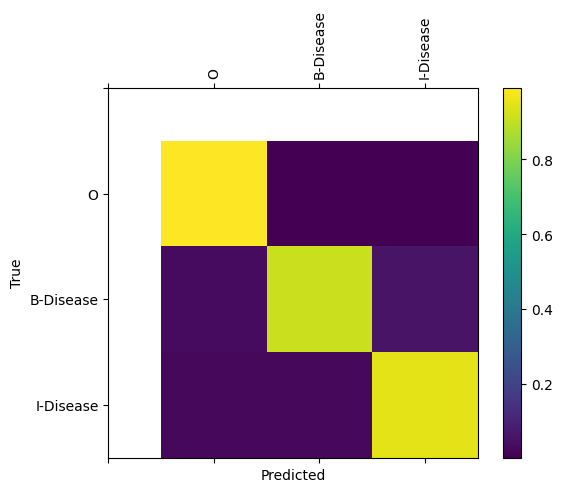

In [41]:
# evaluate model performance on sample
ner_model.half().evaluate_from_file(
    text_file=os.path.join(NER_DATA_DIR, 'sample_text_dev.txt'),
    labels_file=os.path.join(NER_DATA_DIR, 'sample_labels_dev.txt'),
    output_dir=WORK_DIR,
    add_confusion_matrix=True,
    normalize_confusion_matrix=True,
    batch_size=1
)

click ... to show solution. 

In [42]:
# restart the kernel
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

**Well Done!** 

![DLI Header](images/DLI_Header.png)